In [1]:
import numpy as np
import pandas as pd
import random
import time
import datetime
import json
import pickle
import os

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras import optimizers
from keras.utils.vis_utils import plot_model

from tensorflow.keras import Input
from tensorflow.keras import Model
from tcn import TCN

Using TensorFlow backend.


In [2]:
pd.options.display.max_columns = 25

## Read the data

In [3]:
df = pd.read_excel("../data/Volve production data_daily.xlsx", sep=';', decimal=',')
df

,DATEPRD,WELL_BORE_CODE,NPD_WELL_BORE_CODE,NPD_WELL_BORE_NAME,NPD_FIELD_CODE,NPD_FIELD_NAME,NPD_FACILITY_CODE,NPD_FACILITY_NAME,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P,AVG_CHOKE_UOM,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,BORE_WI_VOL,FLOW_KIND,WELL_TYPE
0,2014-04-07,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,0.00000,0.00000,0.00000,0.00000,0.000000,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,WI
1,2014-04-08,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,NaN,NaN,0.00000,1.003059,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
2,2014-04-09,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,NaN,NaN,0.00000,0.979008,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
3,2014-04-10,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,NaN,NaN,0.00000,0.545759,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
4,2014-04-11,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,310.37614,96.87589,277.27826,0.00000,1.215987,%,33.09788,10.47992,33.07195,0.0,0.0,0.0,NaN,production,OP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15629,2016-09-14,NO 15/9-F-5 AH,5769,15/9-F-5,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,NaN,NaN,0.27272,0.636088,%,0.07776,0.22879,0.01862,0.0,0.0,0.0,NaN,production,OP
15630,2016-09-15,NO 15/9-F-5 AH,5769,15/9-F-5,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,NaN,NaN,0.28686,0.670794,%,0.08545,0.22914,0.00631,0.0,0.0,0.0,NaN,production,OP
15631,2016-09-16,NO 15/9-F-5 AH,5769,15/9-F-5,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,NaN,NaN,0.28604,0.664393,%,0.08544,0.22896,0.01181,0.0,0.0,0.0,NaN,production,OP
15632,2016-09-17,NO 15/9-F-5 AH,5769,15/9-F-5,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,NaN,NaN,0.27212,0.624660,%,0.07497,0.22846,0.02576,0.0,0.0,0.0,NaN,production,OP


In [4]:
# df[['AVG_DOWNHOLE_PRESSURE', 'AVG_DP_TUBING', 'AVG_ANNULUS_PRESS', 'AVG_WHP_P']] /= 14.504
df[['AVG_WHP_P']] /= 14.504 # psi to bar

In [5]:
int_cols = df.select_dtypes(include=['int64']).columns
float_cols = df.select_dtypes(include=['float64']).columns
obj_cols = df.select_dtypes(include=['object']).columns

not_float_cols = df.select_dtypes(include=['datetime64[ns]', 'object', 'int64']).columns

In [6]:
df = df.drop(columns=['WELL_BORE_CODE', 'NPD_WELL_BORE_NAME', 'NPD_FIELD_CODE', 'NPD_FIELD_NAME', 'NPD_FACILITY_CODE', 'NPD_FACILITY_NAME', 'AVG_CHOKE_UOM'])

In [7]:
units1 = {'ON_STREAM_HRS': 'hrs',
          'AVG_DOWNHOLE_PRESSURE': 'bar',
          'AVG_DOWNHOLE_TEMPERATURE': 'C', 
          'AVG_DP_TUBING': 'bar',
          'AVG_ANNULUS_PRESS': 'bar',
          'AVG_CHOKE_SIZE_P': '%',
          'AVG_WHP_P': 'bar',
          'AVG_WHT_P': 'C',
          'DP_CHOKE_SIZE': 'mm',
          'BORE_OIL_VOL': 'bbl',
          'BORE_GAS_VOL': 'bbl',
          'BORE_WAT_VOL': 'bbl',
          'BORE_WI_VOL': 'bbl'}

In [8]:
well_num = 7405
well = df[df['NPD_WELL_BORE_CODE'] == well_num]
well = well.drop(columns=['NPD_WELL_BORE_CODE', 'FLOW_KIND', 'BORE_WI_VOL', 'AVG_ANNULUS_PRESS'])

well = well.drop(well.shape[0] - 1)
well = well.drop(0)

In [9]:
well[well['WELL_TYPE'] == 'WI']

,DATEPRD,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,WELL_TYPE
91,2014-07-07,24.0,215.070057,108.13567,162.40675,46.824566,3.630951,54.966429,24.2335,522.0,77846.76,154.47,WI


In [10]:
well = well.drop(columns=['WELL_TYPE'])

In [11]:
well.isna().sum()

DATEPRD                     0
ON_STREAM_HRS               0
AVG_DOWNHOLE_PRESSURE       3
AVG_DOWNHOLE_TEMPERATURE    3
AVG_DP_TUBING               3
AVG_CHOKE_SIZE_P            0
AVG_WHP_P                   0
AVG_WHT_P                   0
DP_CHOKE_SIZE               0
BORE_OIL_VOL                0
BORE_GAS_VOL                0
BORE_WAT_VOL                0
dtype: int64

In [12]:
well = well.fillna(method='ffill')

In [13]:
def plot_well(well, index=""):
    plt.figure(figsize=(18, 50))

    if index != "" or 'DATEPRD' in well.columns:
        for i, col in enumerate(well.columns[1:]):
            plt.subplot(len(well.columns), 1, i+1)
            if 'DATEPRD' in well.columns:
                plt.plot(well.DATEPRD, well[col], '.-')
            elif index != "":
                plt.plot(well[index], well[col], '.-')
            plt.title(f'{col}')
            plt.ylabel(units1[col])
            plt.grid(True)
#         plt.axvline('2014-04-07', color="black", ls="--")
    else:
        for i, col in enumerate(well.columns):
            plt.subplot(len(well.columns), 1, i+1)
            plt.plot(well[col], '.-')
            plt.title(f'{col}')
            plt.ylabel(units1[col])
            plt.grid(True)

C:\Users\Asus\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


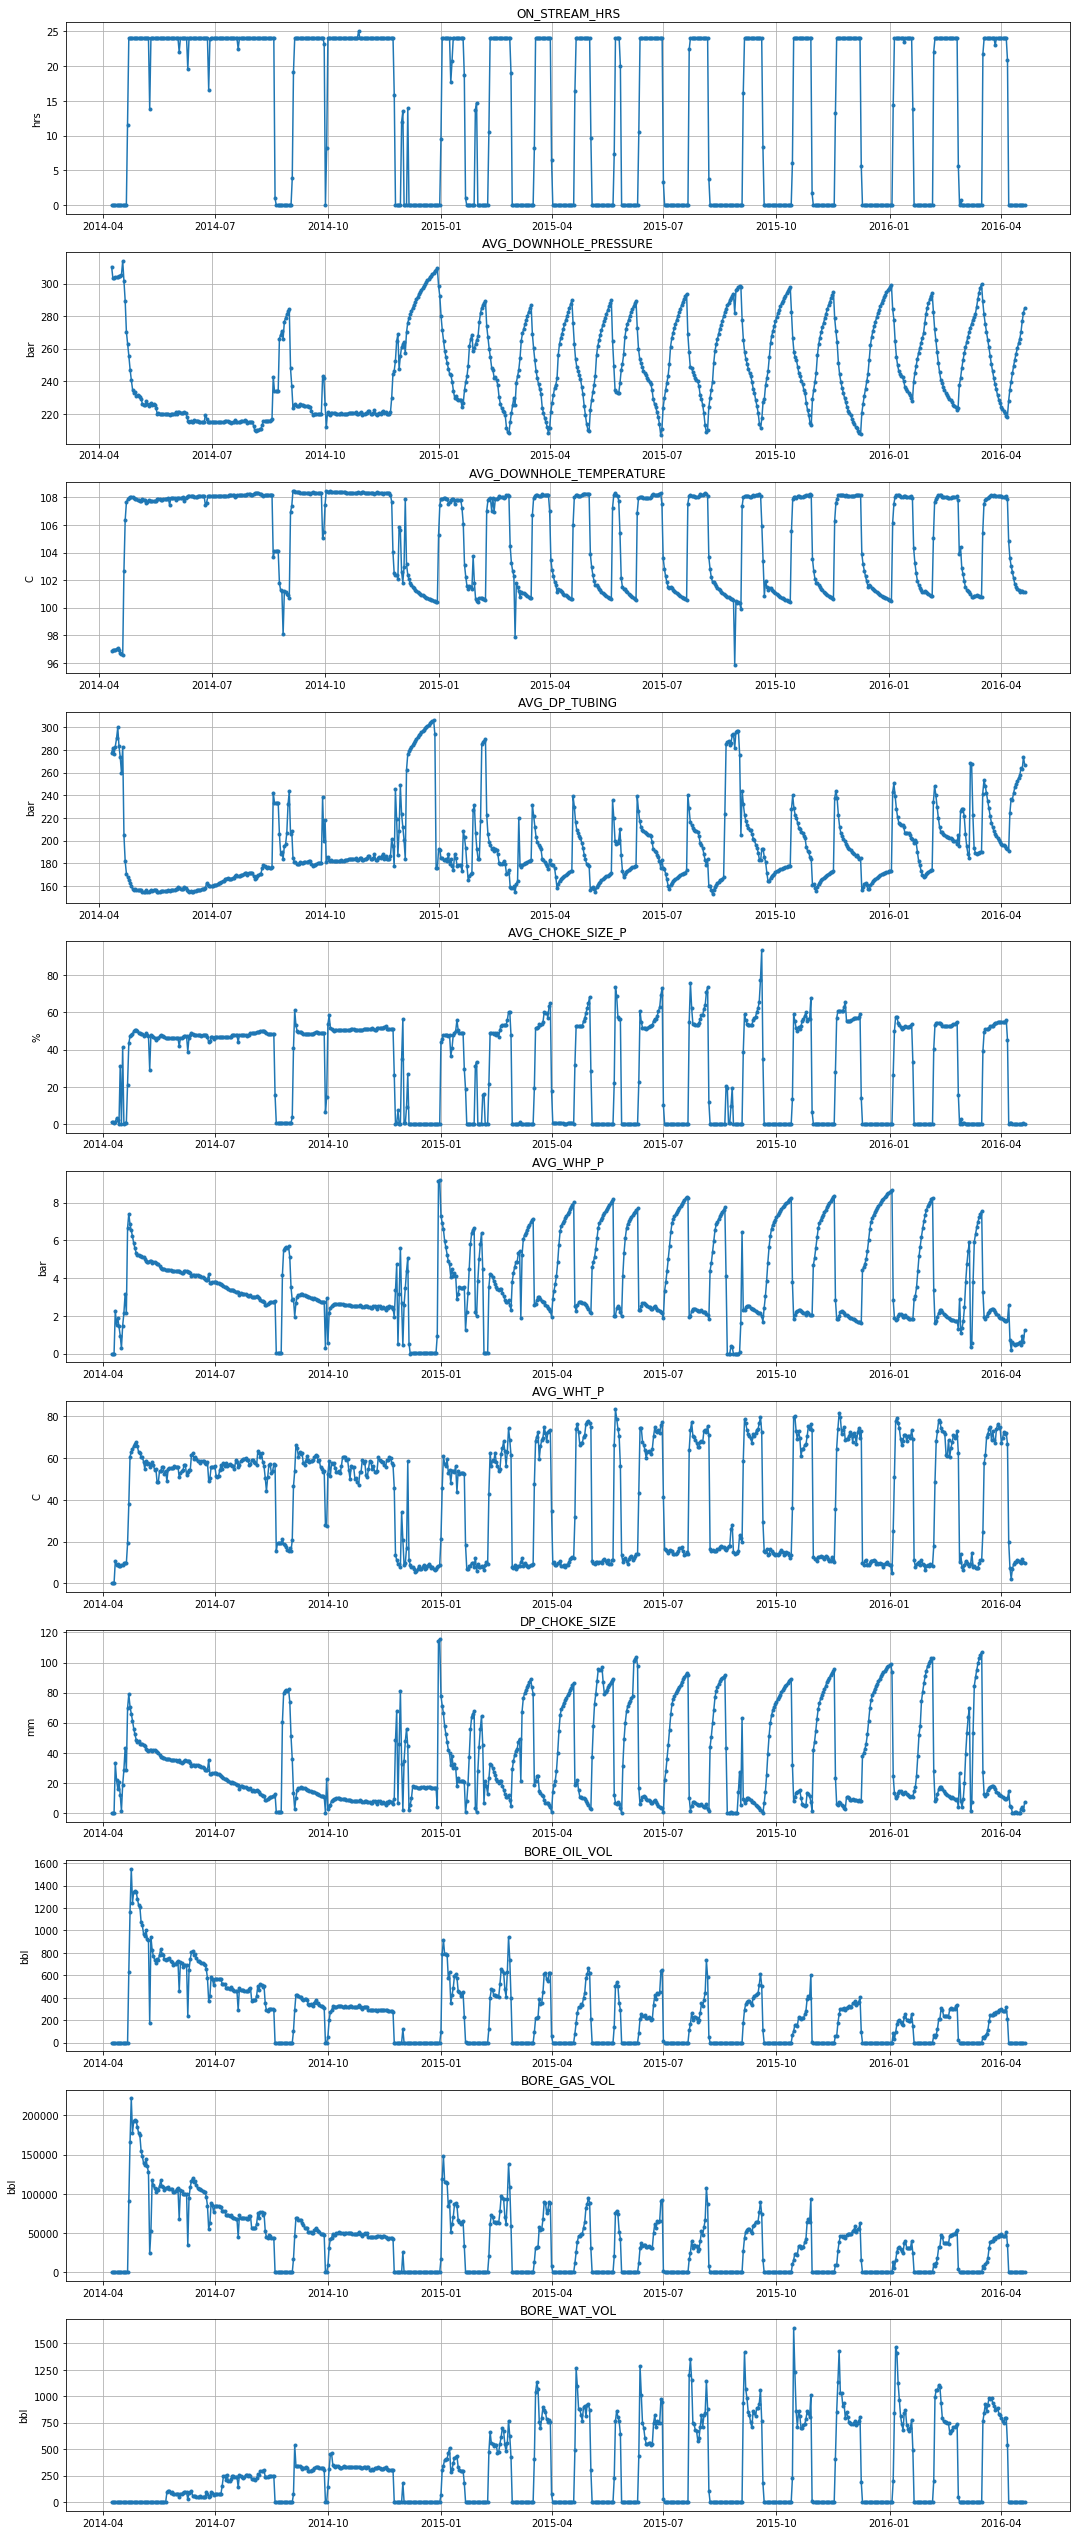

In [14]:
plot_well(well)

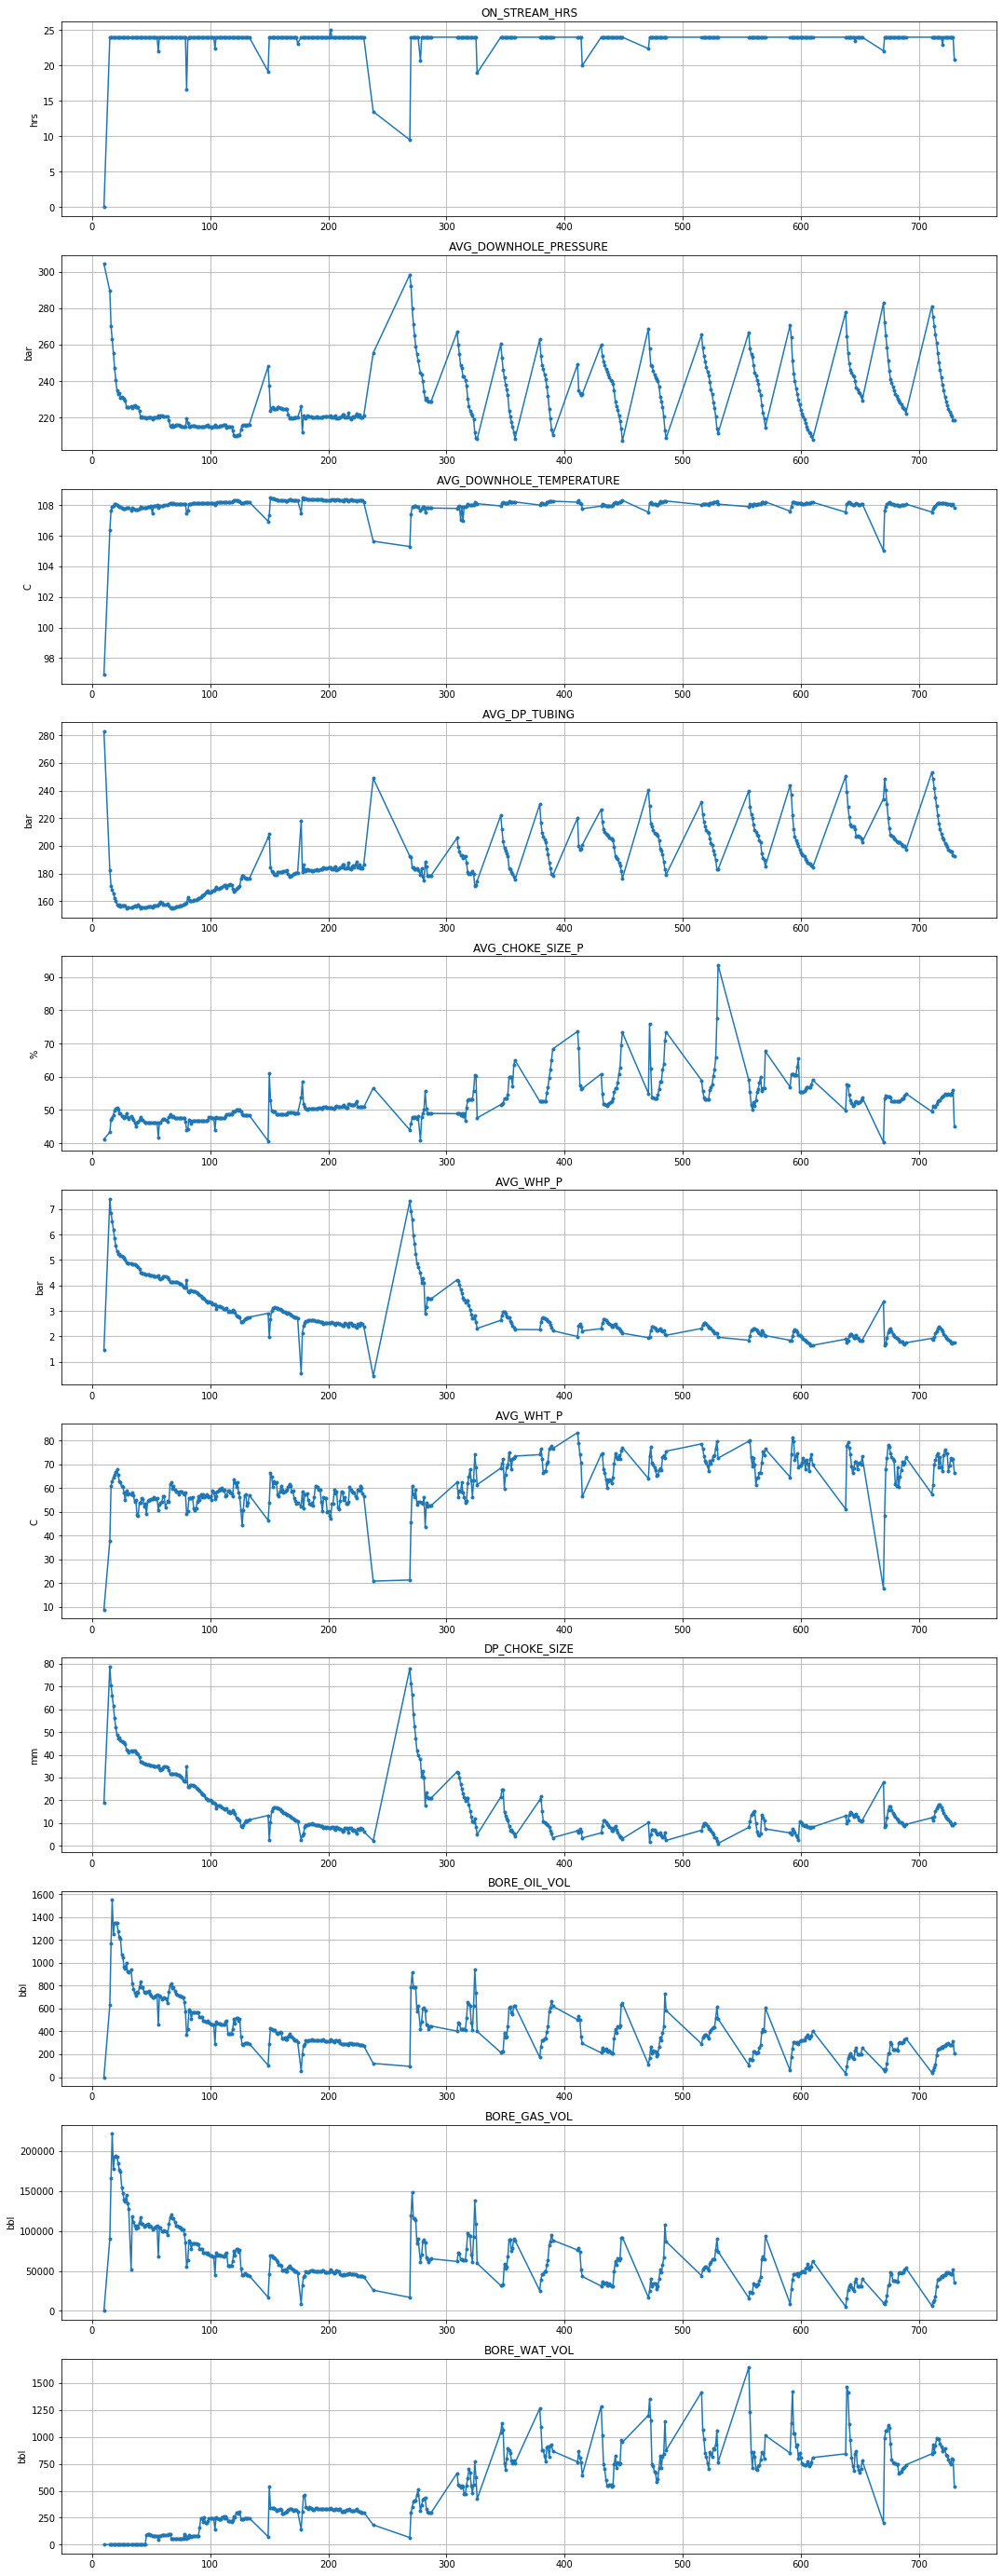

In [15]:
tmp = well[well['AVG_CHOKE_SIZE_P'] > 40]
tmp = tmp.drop(columns=['DATEPRD'])
plot_well(tmp)

In [16]:
tmp[200:].AVG_CHOKE_SIZE_P.mean()

55.366416943575466

In [17]:
def plot_color(df, units1):
    outputs = df[['DATEPRD', 'BORE_OIL_VOL', 'BORE_GAS_VOL', 'BORE_WAT_VOL']]
    inputs = df.drop(columns=['BORE_OIL_VOL', 'BORE_GAS_VOL', 'BORE_WAT_VOL'], axis=1)
    outputs = outputs.set_index("DATEPRD")
    inputs = inputs.set_index("DATEPRD")
    
    plt.figure(figsize=(20, 40))

    plt.subplot(711)
    plt.plot(inputs.index, inputs["AVG_WHP_P"], '.-', label="Wellhead")
    # plt.plot(inputs.index, inputs["AVG_DOWNHOLE_PRESSURE"], '.-', label="Bottomhole")
    # plt.plot(inputs.index, inputs["AVG_DP_TUBING"], label="DP Tubing", ls="--")
    plt.title("Wellhead pressure", fontsize=16)
    plt.ylabel(units1['AVG_WHP_P'])
    # plt.axvline(inputs.index[train_len], color="black", ls="--", lw=1.5)
    plt.grid(True)
    plt.legend(prop={'size': 16})

    plt.subplot(712)
    plt.plot(inputs.index, inputs["AVG_DOWNHOLE_PRESSURE"], '.-', label="Bottomhole")
    plt.title("Bottomhole pressure", fontsize=16)
    plt.ylabel(units1['AVG_WHP_P'])
    # plt.axvline(inputs.index[train_len], color="black", ls="--", lw=1.5)
    plt.grid(True)
    plt.legend(prop={'size': 16})

    plt.subplot(713)
    plt.plot(inputs.index, inputs["AVG_WHT_P"], '.-', label="Wellhead")
    plt.plot(inputs.index, inputs["AVG_DOWNHOLE_TEMPERATURE"], '.-', label="Bottomhole")
    plt.title("Temperatures", fontsize=16)
    plt.ylabel(units1["AVG_WHT_P"])
    # plt.axvline(inputs.index[train_len], color="black", ls="--", lw=1.5)
    plt.grid(True)
    plt.legend(prop={'size': 16})

    plt.subplot(714)
    plt.plot(inputs.index, inputs["AVG_CHOKE_SIZE_P"], '.-', label="Wellhead", color="black")
    plt.title("Choke opening", fontsize=16)
    plt.ylabel(units1['AVG_CHOKE_SIZE_P'])
    # plt.axvline(inputs.index[train_len], color="black", ls="--", lw=1.5)
    plt.grid(True)
    plt.legend(prop={'size': 16})

    plt.subplot(715)
    plt.plot(inputs.index, inputs["DP_CHOKE_SIZE"], '.-', label="Wellhead", color="brown")
    plt.title("Choke size", fontsize=16)
    plt.ylabel(units1['DP_CHOKE_SIZE'])
    # plt.axvline(inputs.index[train_len], color="black", ls="--", lw=1.5)
    plt.grid(True)
    plt.legend(prop={'size': 16})

    plt.subplot(716)
    plt.plot(inputs.index,  outputs["BORE_OIL_VOL"], '.-', color="tab:purple", label="Oil")
    # plt.plot(outputs["BORE_GAS_VOL"], color="tab:purple", label="Gas")
    plt.plot(inputs.index, outputs["BORE_WAT_VOL"], '.-', color="tab:green", label="Water")
    plt.title("Flow rates", fontsize=16)
    plt.ylabel(units1["BORE_OIL_VOL"])
    # plt.axvline(inputs.index[train_len], color="black", ls="--", lw=1.5)
    plt.grid(True)
    plt.legend(prop={'size': 16})

    plt.subplot(717)
    plt.plot(inputs.index, outputs["BORE_GAS_VOL"], '.-', color="tab:red", label="Gas")
    plt.title("Flow rates", fontsize=16)
    plt.ylabel(units1["BORE_OIL_VOL"])
    # plt.axvline(inputs.index[train_len], color="black", ls="--", lw=1.5)
    plt.grid(True)
    plt.legend(prop={'size': 16})

    plt.show();
    
    return inputs, outputs

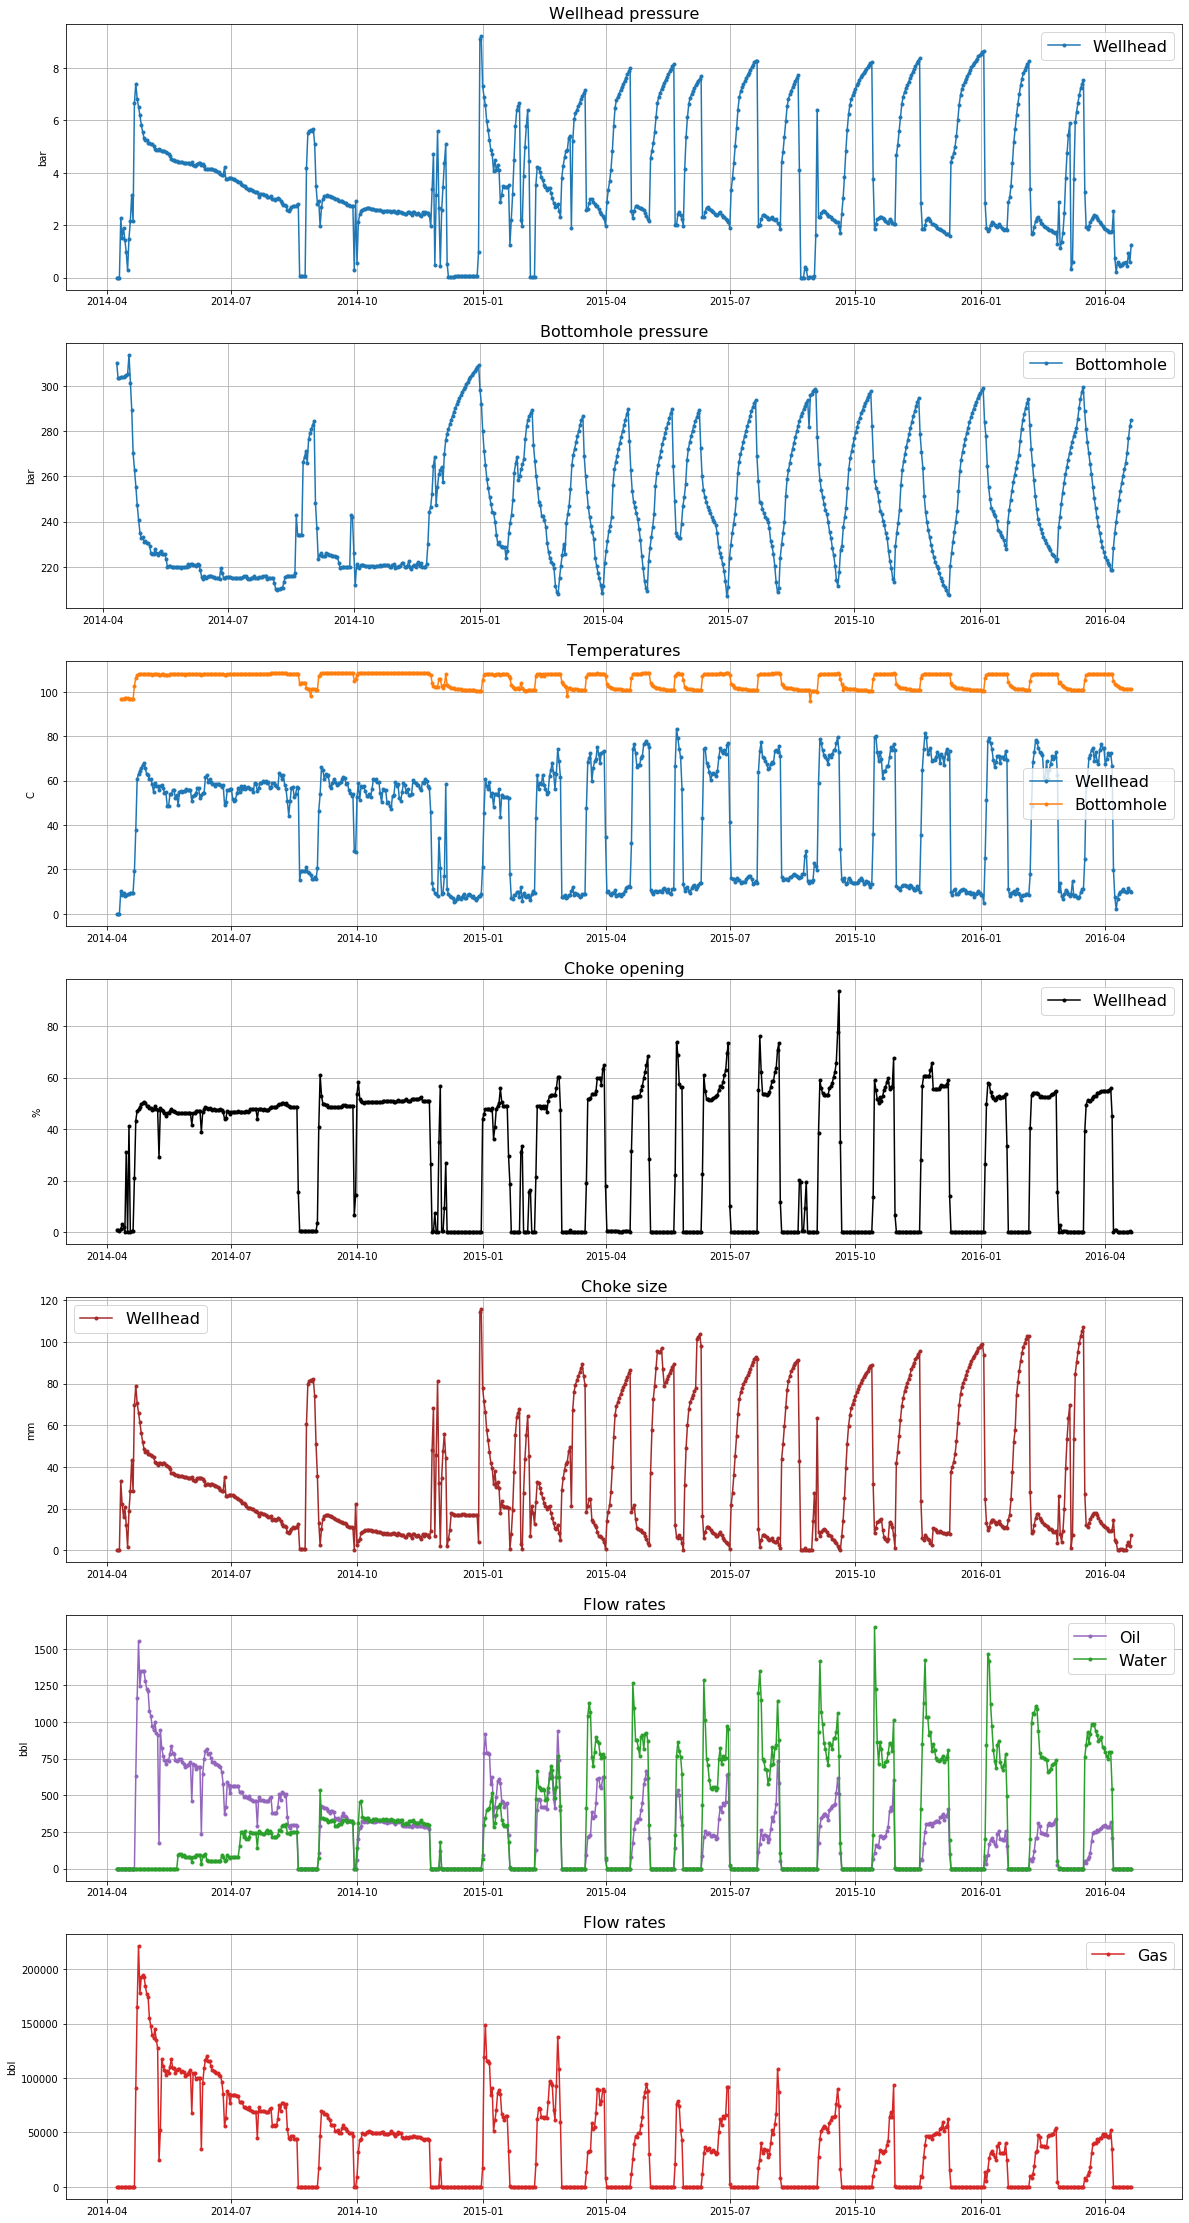

In [18]:
inputs, outputs = plot_color(well, units1)

In [28]:
# choose training set size 

all_len = len(inputs)
train_len = len(outputs) * 2 // 3
train_len, all_len

(496, 744)

#--------------------------------

In [2]:
err_upper_limit = 14
n_epochs = 350

In [3]:
scheme_num = 1
date = str(datetime.datetime.now())[:-16]
path = f'logs/{date}'

if not os.path.exists(path):
    os.makedirs(path)

print (f'logs path: {path}')

logs path: logs/2021-04-20


In [4]:
scheme_nums = [1]
results = {}
for scheme in scheme_nums:
    results.update({'model_names': [], 'models': [], 'train_errs': [], 'test_errs': [], 'times': []})

## Data preparation

In [94]:
def split_sequence(sequences, n_steps, n_features_in, n_features_out): 
    X1, y1 = sequences[:, :n_features_in], sequences[:, -n_features_out:]
    X, y = [], []
    for i in range(len(sequences)): 
        # find the end of this pattern 
        end_ix = i + n_steps 
        # check if we are beyond the dataset 
        if end_ix > len(sequences) - 1: 
            break
        # gather input and output parts of the pattern 
        seq_x, seq_y = X1[i:end_ix, :], y1[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [95]:
def error(pred, g_truth):
    return (abs(pred - g_truth) / (g_truth.max(axis=0) - g_truth.min(axis=0))) * 100

## MLP

In [37]:
# split a multivariate sequence into samples 

n_steps = 60
n_features_in = 2
n_features_out = 3

raw_seq1 = np.hstack((inputs[:train_len], outputs[:train_len])) # ins and outs - train
true_data = np.hstack((inputs, outputs)) # ins and outs - all

# normalize the data
scaler = MinMaxScaler()
raw_seq1_norm = scaler.fit_transform(raw_seq1) # norm all
true_data_norm = scaler.transform(true_data)

X, y = split_sequence(raw_seq1_norm, n_steps, n_features_in, n_features_out)
X_all, _ = split_sequence(true_data_norm, n_steps, n_features_in, n_features_out)

X.shape, y.shape, X_all.shape

((437, 60, 2), (437, 3), (686, 60, 2))

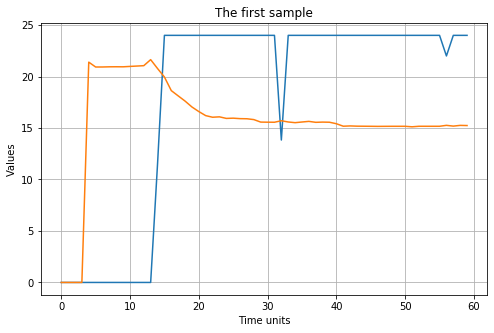

In [38]:
# plot the first sample 

plt.figure(figsize=(8, 5))
plt.plot(raw_seq1[:n_steps, :n_features_in])
plt.title("The first sample")
plt.xlabel("Time units")
plt.ylabel("Values")
plt.grid(True)
plt.show();

In [39]:
# flatten input

n_input = n_steps * n_features_in
X_reshaped = X.reshape((X.shape[0], n_input))
X_all_reshaped = X_all.reshape((X_all.shape[0], n_input))

X_reshaped.shape, y.shape

((437, 120), (437, 3))

In [40]:
# define MLP model

model = Sequential()
model.add(Dense(50, activation='relu', input_dim=n_input))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dense(n_features_out))

model_name = "MLP-1"
scheme_num = 1

# plot_model(model, to_file=model_name + '.png', show_shapes=True, show_layer_names=True)

In [41]:
optimizer = optimizers.Adam(lr=1e-4)
model.compile(loss='mse', optimizer=optimizer)

In [42]:
# train the model

start_time = time.time()

# fit model
model_inf = model.fit(X_reshaped, y, epochs=1300, verbose=1, batch_size=32) # 1300
#verbose 1 - show convergence, 0 - dont show

delta_time = time.time() - start_time
cur_time = datetime.datetime.now()

Epoch 1/1300
437/437 [==============================] - 1s 2ms/step - loss: 0.1504
Epoch 2/1300
437/437 [==============================] - 0s 71us/step - loss: 0.1104
Epoch 3/1300
437/437 [==============================] - 0s 80us/step - loss: 0.0799
Epoch 4/1300
437/437 [==============================] - 0s 73us/step - loss: 0.0641
Epoch 5/1300
437/437 [==============================] - 0s 75us/step - loss: 0.0560
Epoch 6/1300
437/437 [==============================] - 0s 78us/step - loss: 0.0542
Epoch 7/1300
437/437 [==============================] - 0s 75us/step - loss: 0.0496
Epoch 8/1300
437/437 [==============================] - 0s 80us/step - loss: 0.0452
Epoch 9/1300
437/437 [==============================] - 0s 73us/step - loss: 0.0444
Epoch 10/1300
437/437 [==============================] - 0s 82us/step - loss: 0.0402
Epoch 11/1300
437/437 [==============================] - 0s 73us/step - loss: 0.0398
Epoch 12/1300
437/437 [==============================] - 0s 73us/step - los

437/437 [==============================] - 0s 87us/step - loss: 0.0105
Epoch 193/1300
437/437 [==============================] - 0s 82us/step - loss: 0.0110
Epoch 194/1300
437/437 [==============================] - 0s 84us/step - loss: 0.0119
Epoch 195/1300
437/437 [==============================] - 0s 80us/step - loss: 0.0111
Epoch 196/1300
437/437 [==============================] - 0s 82us/step - loss: 0.0109
Epoch 197/1300
437/437 [==============================] - 0s 80us/step - loss: 0.0107
Epoch 198/1300
437/437 [==============================] - 0s 82us/step - loss: 0.0108
Epoch 199/1300
437/437 [==============================] - 0s 75us/step - loss: 0.0111
Epoch 200/1300
437/437 [==============================] - 0s 94us/step - loss: 0.0107
Epoch 201/1300
437/437 [==============================] - 0s 89us/step - loss: 0.0107
Epoch 202/1300
437/437 [==============================] - 0s 87us/step - loss: 0.0104
Epoch 203/1300
437/437 [==============================] - 0s 89us/ste

437/437 [==============================] - 0s 78us/step - loss: 0.0069
Epoch 382/1300
437/437 [==============================] - 0s 80us/step - loss: 0.0066
Epoch 383/1300
437/437 [==============================] - 0s 78us/step - loss: 0.0068
Epoch 384/1300
437/437 [==============================] - 0s 87us/step - loss: 0.0072
Epoch 385/1300
437/437 [==============================] - 0s 87us/step - loss: 0.0067
Epoch 386/1300
437/437 [==============================] - 0s 87us/step - loss: 0.0072
Epoch 387/1300
437/437 [==============================] - 0s 87us/step - loss: 0.0063
Epoch 388/1300
437/437 [==============================] - 0s 89us/step - loss: 0.0073
Epoch 389/1300
437/437 [==============================] - 0s 84us/step - loss: 0.0069
Epoch 390/1300
437/437 [==============================] - 0s 82us/step - loss: 0.0070
Epoch 391/1300
437/437 [==============================] - 0s 84us/step - loss: 0.0076
Epoch 392/1300
437/437 [==============================] - 0s 75us/ste

437/437 [==============================] - 0s 78us/step - loss: 0.0046
Epoch 572/1300
437/437 [==============================] - 0s 80us/step - loss: 0.0055
Epoch 573/1300
437/437 [==============================] - 0s 80us/step - loss: 0.0050
Epoch 574/1300
437/437 [==============================] - 0s 87us/step - loss: 0.0052
Epoch 575/1300
437/437 [==============================] - 0s 82us/step - loss: 0.0050
Epoch 576/1300
437/437 [==============================] - 0s 86us/step - loss: 0.0059
Epoch 577/1300
437/437 [==============================] - 0s 84us/step - loss: 0.0047
Epoch 578/1300
437/437 [==============================] - 0s 80us/step - loss: 0.0046
Epoch 579/1300
437/437 [==============================] - 0s 87us/step - loss: 0.0049
Epoch 580/1300
437/437 [==============================] - 0s 84us/step - loss: 0.0049
Epoch 581/1300
437/437 [==============================] - 0s 84us/step - loss: 0.0050
Epoch 582/1300
437/437 [==============================] - 0s 84us/ste

437/437 [==============================] - 0s 75us/step - loss: 0.0038
Epoch 762/1300
437/437 [==============================] - 0s 78us/step - loss: 0.0041
Epoch 763/1300
437/437 [==============================] - 0s 79us/step - loss: 0.0041
Epoch 764/1300
437/437 [==============================] - 0s 82us/step - loss: 0.0042
Epoch 765/1300
437/437 [==============================] - 0s 78us/step - loss: 0.0039
Epoch 766/1300
437/437 [==============================] - 0s 78us/step - loss: 0.0044
Epoch 767/1300
437/437 [==============================] - 0s 75us/step - loss: 0.0039
Epoch 768/1300
437/437 [==============================] - 0s 84us/step - loss: 0.0044
Epoch 769/1300
437/437 [==============================] - 0s 75us/step - loss: 0.0040
Epoch 770/1300
437/437 [==============================] - 0s 82us/step - loss: 0.0042
Epoch 771/1300
437/437 [==============================] - 0s 75us/step - loss: 0.0039
Epoch 772/1300
437/437 [==============================] - 0s 78us/ste

437/437 [==============================] - 0s 80us/step - loss: 0.0038
Epoch 951/1300
437/437 [==============================] - 0s 73us/step - loss: 0.0033
Epoch 952/1300
437/437 [==============================] - 0s 75us/step - loss: 0.0032
Epoch 953/1300
437/437 [==============================] - 0s 82us/step - loss: 0.0039
Epoch 954/1300
437/437 [==============================] - 0s 78us/step - loss: 0.0033
Epoch 955/1300
437/437 [==============================] - 0s 78us/step - loss: 0.0033
Epoch 956/1300
437/437 [==============================] - 0s 80us/step - loss: 0.0036
Epoch 957/1300
437/437 [==============================] - 0s 78us/step - loss: 0.0033
Epoch 958/1300
437/437 [==============================] - 0s 82us/step - loss: 0.0039
Epoch 959/1300
437/437 [==============================] - 0s 80us/step - loss: 0.0037
Epoch 960/1300
437/437 [==============================] - 0s 78us/step - loss: 0.0031
Epoch 961/1300
437/437 [==============================] - 0s 82us/ste

437/437 [==============================] - 0s 82us/step - loss: 0.0032
Epoch 1139/1300
437/437 [==============================] - 0s 78us/step - loss: 0.0029
Epoch 1140/1300
437/437 [==============================] - 0s 82us/step - loss: 0.0028
Epoch 1141/1300
437/437 [==============================] - 0s 80us/step - loss: 0.0031
Epoch 1142/1300
437/437 [==============================] - 0s 75us/step - loss: 0.0028
Epoch 1143/1300
437/437 [==============================] - 0s 80us/step - loss: 0.0036
Epoch 1144/1300
437/437 [==============================] - 0s 78us/step - loss: 0.0034
Epoch 1145/1300
437/437 [==============================] - 0s 78us/step - loss: 0.0038
Epoch 1146/1300
437/437 [==============================] - 0s 78us/step - loss: 0.0031
Epoch 1147/1300
437/437 [==============================] - 0s 82us/step - loss: 0.0033
Epoch 1148/1300
437/437 [==============================] - 0s 75us/step - loss: 0.0032
Epoch 1149/1300
437/437 [==============================] - 

In [43]:
# obtain the model results: make a prediction and calculate an error

y_pred_norm = model.predict(X_all_reshaped, verbose=0)
table_norm = np.hstack((true_data_norm[:, :-n_features_out], np.vstack((raw_seq1_norm[:n_steps, -n_features_out:], y_pred_norm))))
table = scaler.inverse_transform(table_norm) # denormalize all
preds = table[:, -n_features_out:]
errs = error(preds, true_data[:, -n_features_out:]) # calc error between denormalized y_pred and real y

# write the model results to the file

data = {}
data["model_name"] = model_name
data["loss"] = model_inf.history['loss']
data["train_size"] = train_len
data["preds"] = preds.tolist()
data["g_truth"] = true_data[:, -n_features_out:].tolist()
data["errors"] = errs.tolist()
data["training_time"] = delta_time
data["cur_time"] = str(cur_time)

with open(f'{path}/{model_name}.json', 'w') as file:
    json.dump(data, file)

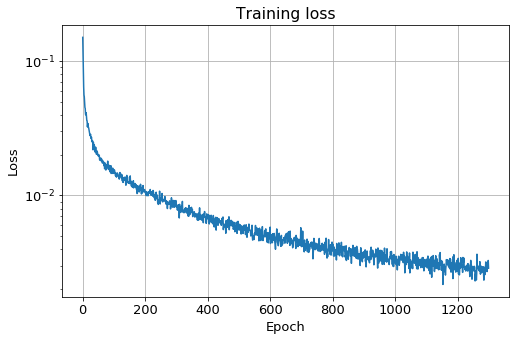

In [44]:
# summarize history for loss
    
fig = plt.figure(figsize=(8, 5))
plt.rcParams.update({'font.size': 13})

plt.plot(data["loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Training loss")
plt.grid(True)
plt.show()

fig.savefig(f'{path}/{model_name}_loss.png', dpi=fig.dpi);

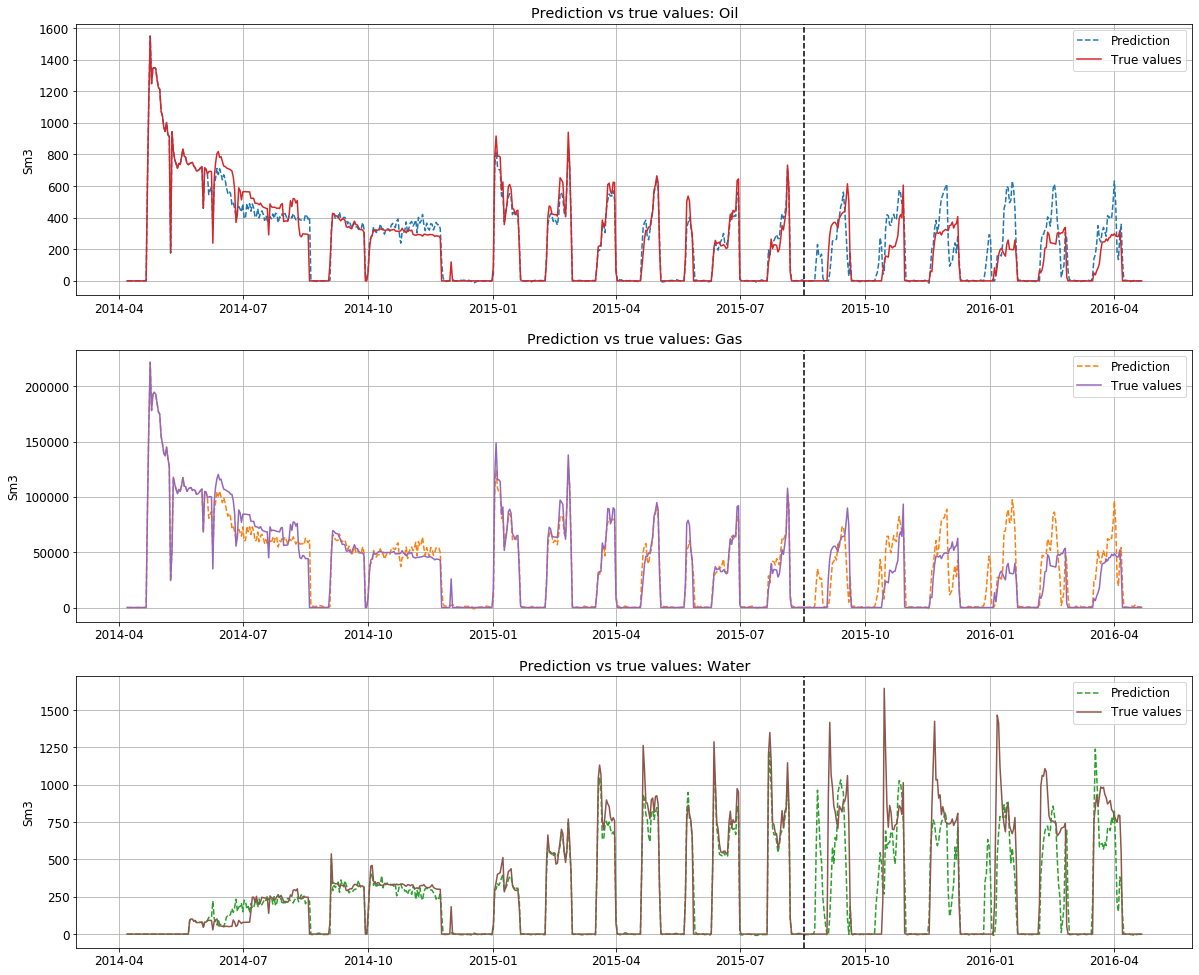

In [45]:
# plot predictions vs true values

fig = plt.figure(figsize=(20, 17))
plt.rcParams.update({'font.size': 12})

plt.subplot(311)
plt.plot(inputs.index, np.array(data["preds"])[:, -3], ls="--", color="tab:blue", label="Prediction") # Predictions using the model
plt.plot(inputs.index, np.array(data["g_truth"])[:, -3], color="tab:red", label="True values")
plt.axvline(inputs.index[data["train_size"]], color="black", ls="--", lw=1.5)
plt.legend()
plt.ylabel(units1["BORE_OIL_VOL"])
plt.title("Prediction vs true values: Oil")
plt.grid(True)

plt.subplot(312)
plt.plot(inputs.index, np.array(data["preds"])[:, -2], ls="--", color="tab:orange", label="Prediction") # Predictions using the model
plt.plot(inputs.index, np.array(data["g_truth"])[:, -2], color="tab:purple", label="True values")
plt.axvline(inputs.index[data["train_size"]], color="black", ls="--", lw=1.5)
plt.legend()
plt.ylabel(units1["BORE_OIL_VOL"])
plt.title("Prediction vs true values: Gas")
plt.grid(True)

plt.subplot(313)
plt.plot(inputs.index, np.array(data["preds"])[:, -1], ls="--", color="tab:green", label="Prediction") # Predictions using the model
plt.plot(inputs.index, np.array(data["g_truth"])[:, -1], color="tab:brown", label="True values")
plt.axvline(inputs.index[data["train_size"]], color="black", ls="--", lw=1.5)
plt.legend()
plt.ylabel(units1["BORE_OIL_VOL"])
plt.title("Prediction vs true values: Water")
plt.grid(True)

fig.savefig(f'{path}/{model_name}_pred.png', dpi=fig.dpi);

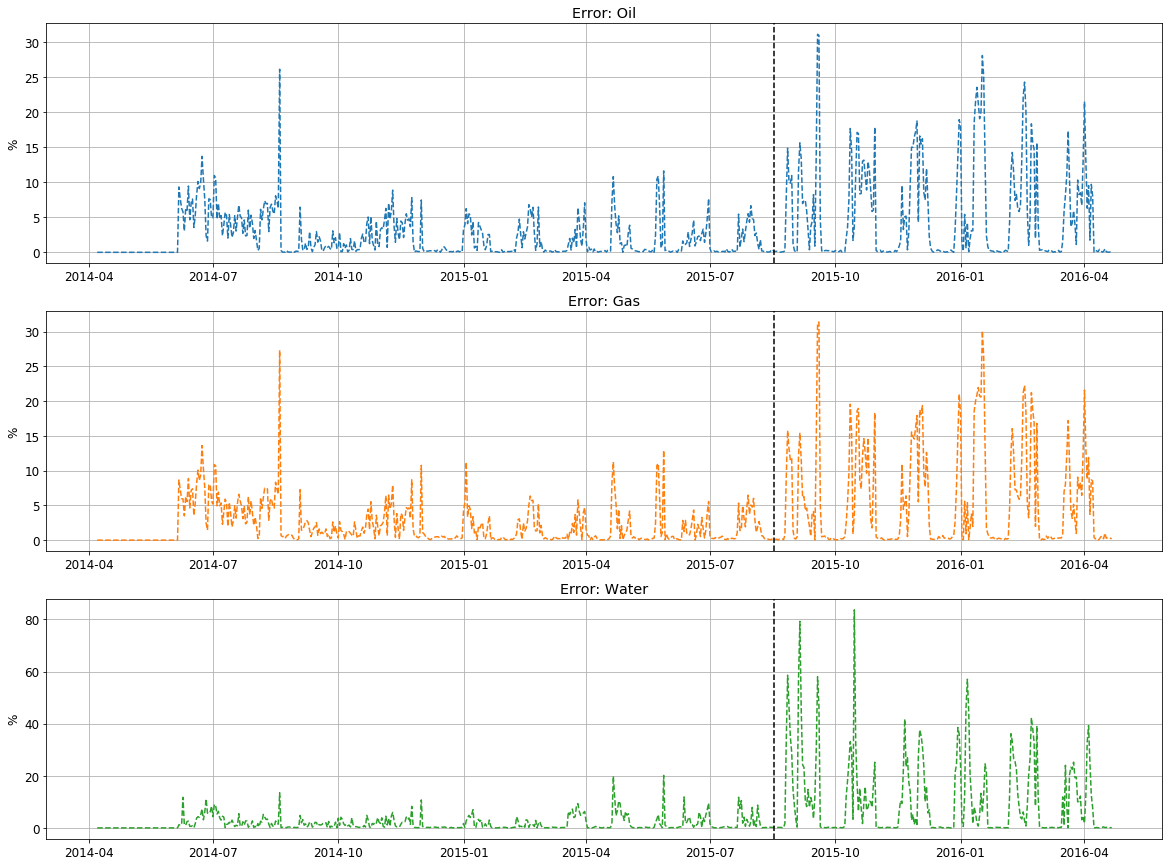

In [46]:
# plot predictions vs true values

fig = plt.figure(figsize=(20, 15))
plt.rcParams.update({'font.size': 12})

plt.subplot(311)
plt.plot(inputs.index, np.array(data["errors"])[:, -3], ls="--", color="tab:blue") # Predictions using the model
plt.axvline(inputs.index[data["train_size"]], color="black", ls="--", lw=1.5)
plt.ylabel("%")
plt.title('Error: Oil')
plt.grid(True)

plt.subplot(312)
plt.plot(inputs.index, np.array(data["errors"])[:, -2], ls="--", color="tab:orange") # Predictions using the model
plt.axvline(inputs.index[data["train_size"]], color="black", ls="--", lw=1.5)
plt.ylabel("%")
plt.title('Error: Gas')
plt.grid(True)

plt.subplot(313)
plt.plot(inputs.index, np.array(data["errors"])[:, -1], ls="--", color="tab:green") # Predictions using the model
plt.axvline(inputs.index[data["train_size"]], color="black", ls="--", lw=1.5)
plt.ylabel("%")
plt.title('Error: Water')
plt.grid(True)

fig.savefig(f'{path}/{model_name}_pred.png', dpi=fig.dpi);

In [47]:
# print the model results

print (f"Experiment time:  %s\n" % (data["cur_time"][:-7]))
print (f"Model name:       %s" % (data["model_name"]))
print (f"Training time:    %.3f sec" % (data["training_time"]))
print (f"Train error:      %.3f" % (np.mean(data["errors"][:data["train_size"]])))
print (f"Test error:       %.3f" % (np.mean(data["errors"][data["train_size"]:])))

Experiment time:  2021-04-16 20:05:39

Model name:       MLP-1
Training time:    49.454 sec
Train error:      1.932
Test error:       7.321


In [ ]:
1 dataset
5:1, 5:0, 5:1, 5:0, 5:1, 5:0, 5:1, 5:0, 5:1, 5:0
                                        
2 dataset
5:1, 5:0, 5:0.7, 5:0, 5:1, 5:0, 5:0.7, 5:0, 5:1, 5:0
                                        
4:0, 0.2, 0.6, 3:0, 0.8, 0.6, 6:0, 0.3, 0.5, 4:0, 0.3, 0.6, 7:0, 0.2, 0.6, 4:0, 0.8, 0.7, 0.8, 4:0, 0.3, 0.7, 0.5, 2:0

4 dataset
5:0, 7:0.55, 5:0, 3:0.65, 4:0, 6:0.5, 5:0, 8:0.45, 2:0, 5:0.55
                    
from real                                        
0.56, 0.0, 0.0, 0.0, 0.0, 0.0, 0.55, 0.51, 0.52, 0.53, 0.57, 0.63, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.55, 0.54, 0.53, 0.56, 0.62, 0.74, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.59, 0.53, 0.53, 0.58, 0.66, 0.35, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.13, 0.52, 0.51
from real 2
0.56, 0.56, 0.68, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.57, 0.61, 0.63, 0.55, 0.56, 0.57, 0.58, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.58, 0.53, 0.52, 0.52, 0.53, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.54, 0.54, 0.53, 0.53, 0.53, 0.54, 0.16, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5

In [ ]:
5:1, 5:0, 5:1, 5:0, 5:1, 5:0, 5:1, 5:0, 5:1, 5:0, 5:1, 5:0, 5:0.7, 5:0, 5:1, 5:0, 5:0.7, 5:0, 5:1, 5:0, 4:0, 0.2, 0.6, 3:0, 0.8, 0.6, 6:0, 0.3, 0.5, 4:0, 0.3, 0.6, 7:0, 0.2, 0.6, 4:0, 0.8, 0.7, 0.8, 4:0, 0.3, 0.7, 0.5, 2:0, 5:0, 7:0.55, 5:0, 3:0.65, 4:0, 6:0.5, 5:0, 8:0.45, 2:0, 5:0.55, 0.56, 0.0, 0.0, 0.0, 0.0, 0.0, 0.55, 0.51, 0.52, 0.53, 0.57, 0.63, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.55, 0.54, 0.53, 0.56, 0.62, 0.74, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.59, 0.53, 0.53, 0.58, 0.66, 0.35, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.13, 0.52, 0.51, 0.56, 0.56, 0.68, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.57, 0.61, 0.63, 0.55, 0.56, 0.57, 0.58, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.58, 0.53, 0.52, 0.52, 0.53, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.54, 0.54, 0.53, 0.53, 0.53, 0.54, 0.16, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5

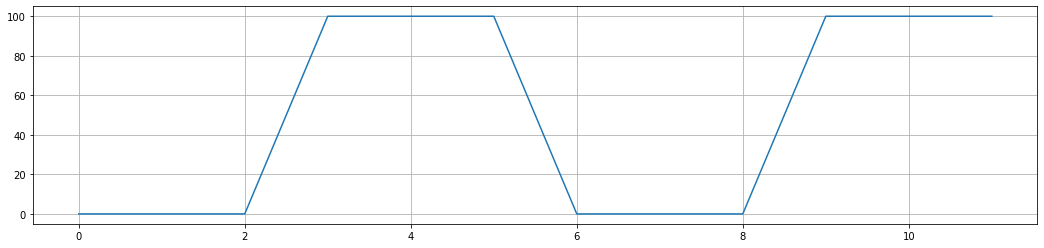

In [20]:
choke = [0, 0, 0, 100, 100, 100, 0, 0, 0, 100, 100, 100]
plt.figure(figsize=(18, 4))
plt.plot(choke)
plt.grid(True)

In [22]:
tmp = [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.55, 0.55, 0.55, 0.55, 0.55, 0, 0, 0, 0, 0, 0.55, 0.55, 0.55, 0.55, 0.55, 0, 0, 0, 0, 0, 0.55, 0.55, 0.55, 0.55, 0.55, 0, 0, 0, 0, 0, 0.55, 0.55, 0.55, 0.55, 0.55, 0, 0, 0, 0, 0, 0.55, 0.55, 0.55, 0.55, 0.55, 0, 0, 0, 0, 0, 0.1, 0.1, 0.1, 0.1, 0.1, 0, 0, 0, 0, 0, 0.1, 0.1, 0.1, 0.1, 0.1, 0, 0, 0, 0, 0, 0.1, 0.1, 0.1, 0.1, 0.1, 0, 0, 0, 0, 0, 0.1, 0.1, 0.1, 0.1, 0.1, 0, 0, 0, 0, 0, 0.1, 0.1, 0.1, 0.1, 0.1]
len(tmp)

150

In [23]:
len([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0.55, 0.55, 0.55, 0.55, 0.55, 0, 0, 0, 0, 0, 0.55, 0.55, 0.55, 0.55, 0.55, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0.1, 0.1, 0.1, 0.1, 0, 0, 0, 0, 0, 0.1, 0.1, 0.1, 0.1, 0.1, 0, 0, 0, 0, 0])

75

Wc ≈ $\frac{Q_w}{Q_w + Q_o}$

GOR ≈ $\frac{Q_g}{Q_o}$

PI ≈ $\frac{Q}{P_r - P_{bh}}$